# Production Model: lemonade stand example 
[![production_model.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/production_model.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/production_model.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/production_model.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/production_model.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/production_model.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/production_model.ipynb)](https://colab.ampl.com)

Description: Basic introduction to AMPL's indexed entities and the Pygwalker Python package via a lemonade stand example

Tags: ampl-lecture, amplpy, ampl, introduction, linear programming, sets, indexing, lemonade stand

Notebook author: Gyorgy Matyasfalvi <<gyorgy@ampl.com>>

References:

* AMPL a Modeling Language for Mathematical Programming -- Robert Fourer et al.

In [1]:
# Install dependencies
%pip install -q amplpy==0.15.0b2 pandas matplotlib

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["open", "gurobi"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

In [3]:
# Import all necessary libraries
import matplotlib.pyplot as plt
import pandas as pd

## Modeling and data

In the upcoming sections, we will build upon our previous examples to formulate a generic production problem that encompasses both the lemonade and mulled wine scenarios. We’ll delve deeper into the usage of sets in AMPL, explore the creation and use of data files, and further investigate AMPL’s data mode and its interplay with APIs.

As demonstrated by the lemonade and mulled wine example, the current approach of hard-coding problem coefficients in our model files necessitates modifications to the model itself each time our problem coefficients change. However, AMPL provides a rich set of features that allow for a convenient separation between our optimization model and its data, such as the problem instance’s coefficients. In AMPL, all model coefficients, such as resource constraints, recipes or profits can be declared as parameters. Values to these parameters can be supplied to AMPL in a separate data file or object, which AMPL can read when in data mode. AMPL’s data mode is optimized for fast ingestion of large data files or objects.

Moving forward, we will refer to models where all problem coefficients are expressed as parameters as parametric models. The models we have seen so far were non-parametric because not all coefficients of our optimization model were expressed as parameters.

Parametric models offer a more streamlined optimization workflow as they enable us to develop general abstract models applicable to all problems belonging to the same class, independent of the problem instances coefficients.

## Production problem formulation
You may have noticed that the two models we discussed for the lemonade and mulled wine stands are quite similar. 
In reality, the core optimization problem we solved in each case is the same, only with different data.

We express our generic production model as the following integer programming problem:

$$
\begin{alignat*}{3}
    & \textrm{Maximize: }   &       & \sum_{j \in P} c_{j} x_{j} - C                    & \\
    & \textrm{Subject To: } & \quad & \sum_{{j \in P}} a_{ij} x_j \leq b_i,             & \forall i \in I \\
    &                       & \quad & \quad \quad \quad  x_{j} \in \mathbb{Z},          &\quad \forall j \in P
\end{alignat*}
$$

Where $P$ is the set of products, $I$ is the set of ingredients, $c_j$ is the profit per unit of product $j$, $x_j$ is the units of product $j$ made, C is a fixed cost, $a_{ij}$ is the usage of ingredient $i$ by unit of product $j$, and $b_i$ is the limit of ingredient $i$.

**Fortunately, AMPL allows us to express the production problem introduced above with the same level of abstraction**.

## Model formulation in AMPL

To formulate our generic production model introduced in (1) in AMPL, we have to introduce [sets](#sets), a fundamental component of AMPL.

In the next section, we will focus on sets before moving on to formulating the parametric model in AMPL and introducing the associated model file. 
Once we have established the abstract model, we will talk about data files, which enable us to convert the abstract model into a specific problem instance.

### Sets
In a typical AMPL model, almost all of the parameters, variables, and constraints are indexed over sets, and many expressions contain operations (usually summations) over sets.
Sets are fundamental in AMPL, and the language offers a wide variety of set types and operations.
To provide a comprehensive understanding of sets, the AMPL book dedicates two full chapters, [Ch. 5](https://ampl.com/wp-content/uploads/Chapter-5-Simple-Sets-and-Indexing-AMPL-Book.pdf) and [Ch. 6](https://ampl.com/wp-content/uploads/Chapter-6-Compound-Sets-and-Indexing-AMPL-Book.pdf) on this topic, as well as sections A.2, A.3, A.4, and A.6 of the [appendix](https://ampl.com/wp-content/uploads/Appendix-A-AMPL-Book.pdf).

For our production model we will declare two sets: one for our products and one for their ingredients.
Set declarations in AMPL start with the `set` keyword, followed by a set name and a semicolon.

```ampl
# Define indexing sets
set PROD;
set INGR;
```

We will use these sets in our model to index our model parameters, variables, and constraints. 
`PROD` will contain product identifiers such as `lemonade` or `ice_tea`, essentially our non-parametric variable names.
`INGR` will contain names of our ingredients such as `sugar`, `tea_bag` etc.

It's important to note that at this point, we have not assigned any set members to the sets introduced above.
Since we want to keep this model completely parametric, we will assign set members in the data file.
However, AMPL does allow for set member assignment in the model file if desired, but doing so would not maintain the model's abstract nature.

<pre style="background-color:None">
<code style="background-color:None">
    <span style="color: darkgreen; font-weight: bold">set</span> <i>name alias<sub>opt</sub> indexing<sub>opt</sub> attributes<sub>opt</sub> </i>;

    <i>attributes: </i>
        <span style="color: darkgreen; font-weight: bold">dimen</span> <i>n</i> 
        <span style="color: darkgreen; font-weight: bold">within</span> <i>sexpr</i>
        = <i>sexpr</i>
        <span style="color: darkgreen; font-weight: bold">default</span> <i>sexpr</i>
</code>
</pre>

As noted earlier, here *sexpr* stands for set expression:

A set's members may be strings or numbers, ordered or unordered; they may occur singly, or as ordered pairs, triples or longer "tuples". 
Sets may be defined by listing or computing their members explicitly, by applying operations like union and intersection to other sets, or by specifying arbitrary arithmetic or logical conditions for membership.

For example, to generate a set whose members are odd numbers between 1 and 10 we can do the following in AMPL:

```ampl
ampl: set ODDS := {i in 1..10: i mod 2};
ampl: display ODDS;
set ODDS := 1 3 5 7 9;
```

The sequence `1..10` generates a dummy set whose members are: `{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}`.
Then, for all elements of the set `{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}` AMPL performs the modulo operation specified after the colon.
Non-zero return values evaluate to true, and hence odd numbers are included in the set, while the rest are discarded.

Returning to our lemonade and mulled wine examples, if we create a set containing all our products: `{'lemonade', 'iced_tea', 'mulled_wine', 'hot_tea'}` and then would like to create another set with all the tea-based products, this can be achieved as follows in AMPL:

```ampl
ampl: set PROD := {'lemonade', 'iced_tea', 'mulled_wine', 'hot_tea'};
ampl: set TEAS := {j in PROD: match(j, '[Tt][Ee][Aa]')}; 
ampl: display TEAS;
set TEAS := iced_tea hot_tea;
```

For every product, we check the string against the regular expression `[Tt][Ee][Aa]`.
If we find a match, then that string will be included in the `TEAS` set.
In the example above, we have used one of AMPL's built-in regular expression function to perform the check.
For more details regarding built-in string and regular expression functions, refer to [Ch. 13](https://ampl.com/wp-content/uploads/Chapter-13-Command-Scripts-AMPL-Book.pdf) and section A.4.2 of the [appendix](https://ampl.com/wp-content/uploads/Appendix-A-AMPL-Book.pdf) of the AMPL book.


In general, any model component such as parameters or variables, as well as iterated operations like `for` or `let` statements, can be indexed over any set using a standard form of indexing expression.
Additionally, sets themselves may be declared in collections indexed over other sets.
The following sections will cover the indexed model entities necessary for our abstract production model.

## EXERCISE 8

1. In the `%%ampl_eval` code cell below, generate a set named `EVENS` that contains all even numbers between 4 and 19. Begin by defining the range with `param begin` and `param end` parameters. Then construct your set using a condition (aka filter) that checks if the number modulo 2 (`mod 2`) equals zero with the `==` comparison operator. Instead of using the `print` command, utilize `display` to show your results, as it automatically formats the output for better readability.

2. Referencing the previously defined `set PROD`, generate a set named `NONTEAS` with all elements that do not represent products categorized as teas. Use the `!` operator to exclude 'tea' products from your results. Utilize `display` to present your findings clearly.

3. Use AMPL's built-in `card()` function to determine the cardinality of the `EVENS` set and the modified `NONTEAS` set you worked with in questions 1 and 2, respectively. Employ the `display` statement to report the cardinality of each set separately, which provides the number of elements contained in each set.

## SOLUTION

In [4]:
%%ampl_eval
reset;
param begin := 4;
param end := 19;
set EVENS := {i in begin..end: i mod 2 == 0};
display EVENS;

set PROD := {'lemonade', 'iced_tea', 'mulled_wine', 'hot_tea'};
set NONTEAS := {j in PROD: !match(j, '[Tt][Ee][Aa]')};
display NONTEAS;

display card(EVENS);
display card(NONTEAS);

set EVENS := 4 6 8 10 12 14 16 18;

set NONTEAS := lemonade mulled_wine;

card(EVENS) = 8

card(NONTEAS) = 2



## Sets Continued

AMPL supports operators for standard set operations such as union, intersection, and difference. 
For instance, we could have derived our set of `NONTEAS` by calculating the difference between `PROD` and `TEAS`. Here's how this can be accomplished:

In [5]:
%%ampl_eval
reset;
set PROD := {'lemonade', 'iced_tea', 'mulled_wine', 'hot_tea'};
set TEAS := {j in PROD: match(j, '[Tt][Ee][Aa]')};
set NONTEAS := PROD diff TEAS;
display NONTEAS;
display card(NONTEAS);

set NONTEAS := lemonade mulled_wine;

card(NONTEAS) = 2



## Indexed variable declarations

We begin by declaring our $x_j$ variables. 
However, in AMPL we can use a descriptive name for them such as `make`.

To declare `make` in AMPL, we start with the `var` keyword, followed by the variable name, the **indexing set** enclosed in curly braces, integrality and nonnegativity attributes, and a semicolon.

```ampl

# Define the decision variables
var make{PROD} integer, >= 0;
```

`make` is indexed over the set `PROD`, which as mentioned earlier will contain all product identifiers for our production model.

## Indexed parameter declarations
We will declare all of the production model coefficients from (1) as parameters.

Our fixed cost $C$ will be called `fee` and is not indexed, the only difference here to our earlier model files is that we don't assign any value to fee in the model file.

The objective function coefficients $c_j$ indicating the profits per product will be represented by the parameter `profit_per_product` indexed over all products.

The right hand side of our constraints $b_i$ will be named `limit` and indexed over all ingredients, as these are our resources limits.

Finally, our constraint coefficients $a_{ij}$ are expressed as the `usage` parameter indexed over both the ingredients and the products, this matrix essentially encodes our recipes.

In the case of parameters, just like with the variable declarations, the **indexing set** follows the name surrounded by curly braces ending with a semicolon:

```ampl
# Define model parameters
param fee;
param profit_per_product{PROD};
param limit{INGR};
param usage{INGR, PROD};
```
Our parameters are indexed over the sets `PROD` and `INGR` which, as mentioned earlier, will contain all product and ingredient identifiers for our specific problem instance.

## Objective declaration
While we only have one objective function in (1), the function body: $\sum_{j \in P} c_{j} x_{j} - C$ contains an indexed summation.
AMPL generalizes indexed operators, such as $\sum$, by expressions for iterating operations over sets. 

Our objective declaration is similar to what we have seen before, first specifying the direction of optimization, followed by a name, a colon, an expression, and a semicolon:

```ampl
# Define the objective function
maximize total_profit: 
    sum {i in PROD} profit_per_product[i] * make[i] - fee;
```

The keyword `sum` may be followed by any indexing expression. 
The subsequent arithmetic expression is evaluated once for each member of the index set (in our case `PROD`), and all the resulting values are added. 

Thus, the sum above represents the total profit made when selling our products.

Before moving on to constraints, we mention that AMPL allows you to concisely declare multiple objective functions by indexing them.
Since our production model only has one objective function, there is no need for that feature in this model.

## Indexed constraint declarations

In (1) we have a constraint for each ingredient: $\sum_{j \in P} a_{ij} x_{j} \leq b_i,\; \forall i \in I$.
Instead of listing each of them individually, as we have done in the past, we can concisely express all our constraint in essentially one line, since our `limit` and `usage` parameters are indexed by ingredients. 

To declare ingredient constraints in AMPL, we first use the keywords `subject to`, followed by a name, the **indexing set**, a colon, a constraint expression, and a semicolon:

```ampl
# Define the constraints
subject to ingredient_constraints {i in INGR}:
    sum {j in PROD} usage[i,j] * make[j] <= limit[i];
```

The constraint expression following the colon is enforced once for each member of the index set (in our case `INGR`).

## The complete model
Below we introduce the general production model in its parametric form in AMPL in its entirety. 
As you can see it looks very similar to the mathematical formulation in (1). 

```ampl
# Define indexing sets
set PROD;
set INGR;

# Define the decision variables
var make{PROD} integer, >= 0;

# Define model parameters
param fee;
param profit_per_product{PROD};
param limit{INGR};
param usage{INGR, PROD};

# Define the objective function
maximize total_profit: 
    sum {i in PROD} profit_per_product[i] * make[i] - fee;

# Define the constraints
subject to ingredient_constraints {i in INGR}:
    sum {j in PROD} usage[i,j] * make[j] <= limit[i];
```

## Solving instances of our production model

### Loading the model
Let's attempt to access the `production.mod` file located in the `ampl_files/` directory.

We will utilize AMPL's built-in `shell` command, which enables us to execute terminal commands from within AMPL—this saves us from having to exit the AMPL environment.

First, we'll ascertain our current working directory:

In [6]:
%%ampl_eval
shell 'pwd';

/home/lentz/Developer/AMPL/colab.ampl.com/authors/gomfy/ampl-lecture


In [7]:
%%writefile production.mod
# Define indexing sets
set PROD;
set INGR;

# Define the decision variables
var make{PROD} integer, >= 0;

# Define model parameters
param fee;
param profit_per_product{PROD};
param limit{INGR};
param usage{INGR, PROD};

# Define the objective function
maximize total_profit: 
    sum {i in PROD} profit_per_product[i] * make[i] - fee;

# Define the constraints
subject to ingredient_constraints {i in INGR}:
    sum {j in PROD} usage[i,j] * make[j] <= limit[i];


Overwriting production.mod


Next, we will locate the `production.mod` file, which encapsulates our model.

In [8]:
%%ampl_eval
shell 'find .. -name "production.mod"';

../ampl-lecture/production.mod


Once identified, we will employ the `read()` command to load `production.mod` by providing the precise path revealed in the preceding step.

To verify the successful loading of the model, we can use AMPL's `show;` command, which displays all the model entities. Observing the expected entities will confirm that the model is loaded correctly. Note that AMPL would generally issue an error if it were unable to find the file or if there were any issues with its contents.

If we try to solve `production.mod` by itself, understandably, AMPL will complain that it is missing data for various declared entities such as sets and parameters.

In [9]:
ampl = AMPL()
ampl.read("production.mod")
ampl.eval("show;")
ampl.set_option("solver", "gurobi")
# ampl.solve() Attempting to solve would result in an error because the data file is missing


parameters:   fee   limit   profit_per_product   usage

sets:   INGR   PROD

variable:   make

constraint:   ingredient_constraints

objective:   total_profit


In [10]:
%%writefile lemonade.mod
# Define the decision variables
var lemonade integer, >= 0;
var iced_tea integer, >= 0;

# Define the parameter(s)
param fee = 2;

# Define the objective function
maximize profit: 1.5*lemonade + iced_tea - fee;

# Define the constraints
subject to lemon_constraint: lemonade <= 10;
subject to tea_bag_constraint: iced_tea <= 8;
subject to sugar_constraint: 2*lemonade + iced_tea <= 20;


Overwriting lemonade.mod


In [11]:
%%writefile lemonade.dat
# Products (columns of constraint matrix, cardinality equals number of variables)
set PROD := lemonade iced_tea;

# Ingredients (rows of constraint matrix, cardinality equals number of constraints)
set INGR := 
lemon 
tea_bag 
sugar;

# Permit fee
param fee := 2;

# Objective function parameters
param profit_per_product := lemonade 1.5 iced_tea 1.0;

# Constraint right hand side values
param limit := 
lemon     10 
tea_bag    8 
sugar     20;

# Constraint matrix values
param usage:  lemonade      iced_tea :=
lemon         1.0           0.0   
tea_bag       0.0           1.0  
sugar         2.0           1.0 ;

Overwriting lemonade.dat


## Loading the data

As expected, we can supply AMPL with the necessary data via the [APIs](https://ampl.com/products/ampl/apis/), [data connectors](https://ampl.com/products/ampl/data-connectors/) or AMPL data files.

### Loading the data is easy (once you have a data file ;-)

#### Pure AMPL version:

In [12]:
%%ampl_eval
reset;
model production.mod
data lemonade.dat
option solver gurobi;
solve;

Gurobi 12.0.0:Gurobi 12.0.0: optimal solution; objective 15
0 simplex iterations


## Via Python API

In [13]:
ampl = AMPL()
ampl.read("production.mod")
ampl.read_data("lemonade.dat")
ampl.solve(solver="gurobi")
assert ampl.solve_result == "solved"

Gurobi 12.0.0:Gurobi 12.0.0: optimal solution; objective 15
0 simplex iterations


## How to read and create a data file?

So far we have only used AMPL in model mode, but it also has a **data** mode.
AMPL reads its data statements in data mode that is initiated by the `data` command. 
In its most common use, this command consists of the keyword `data` followed by the name of a file:

<pre style="background-color:None">
<code style="background-color:None">
    <span style="color: darkgreen; font-weight: bold">data</span> <i>filename </i>
</code>
</pre>

Similarly as with `model`, the above is a shorthand for: 

<pre style="background-color:None">
<code style="background-color:None">
    <span style="color: darkgreen; font-weight: bold">data</span> ; <span style="color: darkgreen; font-weight: bold">include</span> <i>filename </i>
</code>
</pre>

Once in data mode, AMPL interprets input differently then in model mode.
Lexical rules of AMPL in data mode are designed to enable intuitive data entry.
For example, AMPL treats all white space as a single space and ignores commas. 
This helps us to arrange data into easy-to-read lists and tables when applicable. 

In the next sections we will introduce data files (`.dat` files) by writing two of them, one for the lemonade problem and one for the mulled wine problem, in such a way that they will both work with our generic production model.
These data files will suffice to introduce lists of one and two-dimensional sets and parameters.
However, Chapters [9](https://ampl.com/wp-content/uploads/Chapter-9-Specifying-Data-AMPL-Book.pdf) and [10](https://ampl.com/wp-content/uploads/Chapter-10-Database-Access-AMPL-Book.pdf) of the AMPL book provide more information about specifying data in AMPL.


**AMPL does not care about the file extensions, but it is customary to use `.dat` for files intended to be read in data mode.**


### Lists of one dimensional sets and parameters
For a parameter indexed over a one-dimensional set like the parameter `limit`, the specification of the set can be simply a listing of its members:

```ampl
# Ingredients (rows of constraint matrix, cardinality equals number of constraints)
set INGR := 
lemon 
tea_bag 
sugar;
```

and the parameter's specification may be virtually the same except for the addition of a value after each set member:
```ampl
# Constraint right hand side values
param limit := 
lemon     10 
tea_bag    8 
sugar     20;
```

The parameter specification could equally well be written as
```ampl
param limit := lemon 10 tea_bag 8 sugar 20;
```
since extra spaces and line breaks are ignored.

### Lists of two-dimensional sets and parameters
The extension of data lists to the two-dimensional case is largely straightforward, we will examine it in case of parameters, where two one dimensional sets are used for indexing. 
As an example, consider the following from our production model:

```ampl
# Define indexing sets
set PROD;
set INGR;
param usage{INGR, PROD};
```

The members of `PROD` and `INGR` can be given as for any one-dimensional sets:

```ampl
# Products (columns of coefficient matrix, cardinality equals number of variables)
set PROD := lemonade iced_tea;

# Ingredients (rows of coefficient matrix, cardinality equals number of constraints)
set INGR := 
lemon     10 
tea_bag    8 
sugar     20;
```

Data values for a parameter indexed over two sets, such as the parameter `usage` from our production model are naturally specified in a table as follows:

```ampl
# Constraint matrix values
param usage:  lemonade      iced_tea :=
lemon         1.0           0.0   
tea_bag       0.0           1.0  
sugar         2.0           1.0 ;
```

The row labels give the first index and the column labels the second index, so that for example usage["sugar","lemonade"] is set to 2.0. 
To enable AMPL to recognize this as a table, a colon must follow the parameter name, while the := operator follows the list of column labels.

## DATA FILE EXERCISE 9

1. Using the information provided above, create a `.dat` file for the mulled wine problem. Start by adding a new cell below with the `%%writefile mulled_wine.dat` magic command.

2. After creating the `.dat` file, load and solve the mulled wine problem in a new cell. You can use the `%%ampl_eval` magic command or the Python AMPL API with `ampl = AMPL()`. Ensure you first load the production model before solving the problem.

## DATA FILE SOLUTION 

In [14]:
%%writefile mulled_wine.dat
# Products (columns of coefficient matrix, cardinality equals number of variables)
set PROD := mulled_wine hot_tea;

# Ingredients (rows of coefficient matrix, cardinality equals number of constraints)
set INGR := 
spice 
tea_bag 
sugar
wine;

# Permit fee
param fee := 2;

# Objective function parameters
param profit_per_product := mulled_wine 2.0 hot_tea 1.5;

# Coefficient right hand side values
param limit := 
spice     12 
tea_bag    8 
sugar     30
wine      15;
   
# Coefficient matrix values 
param usage: mulled_wine   hot_tea   :=
spice        2.0           0.0
tea_bag      0.0           1.0 
sugar        4.0           2.0
wine         2.0           0.0;


Overwriting mulled_wine.dat


## `%%ampl_eval` solution

In [15]:
%%ampl_eval
reset;
# Read the model file from the `ampl_files` directory
model production.mod
# Read the data file from the notebook directory as that is the directory where %%writefile wrote the data file
data mulled_wine.dat
option solver gurobi;
solve;

Gurobi 12.0.0:Gurobi 12.0.0: optimal solution; objective 16.5
0 simplex iterations


## Specifying data through APIs
In this section, we will delve into how native objects, such as Pandas DataFrames, can be directly passed to AMPL using its APIs.
AMPL's APIs provide a rich assortment of methods for data passing, the selection of which depends on the working environment (e.g., high-level interpreted languages like Python or compiled languages like C++).

### Load data method
This 'load data' method will load either the lemonade or mulled wine data into AMPL, depending on the argument passed to it.
For more information about `amplpy` methods checkout the [methods section](https://amplpy.readthedocs.io/en/latest/classes/ampl.html#ampl) of the API documentation.

#### Lemonade model and corresponding data in Python lists:
<table>
<tr>
<td>

<pre><code>
# Define the objective function
maximize profit: 1.5*lemonade + iced_tea - fee;

# Define the constraints
subject to lemon_constraint: lemonade <= 10;
subject to tea_bag_constraint: iced_tea <= 8;
subject to sugar_constraint: 2*lemonade + iced_tea <= 20;
</code></pre>

</td>
<td>

<pre><code>
# Python lists for AMPL sets
PROD = ['lemonade', 'iced_tea']
INGR = ['lemon', 'tea_bag', 'sugar']

# Python lists for AMPL params
profit_per_product_data = [1.5, 1.0]
limit_data = [10, 8, 20]
usage_data = [1.0, 0.0,
              0.0, 1.0,
              2.0, 1.0]
</code></pre>

</td>
</tr>
</table>

#### Mulled wine model and corresponding data in Python lists:
<table>
<tr>
<td>

<pre><code>
# Define the objective function
maximize profit: 2*mulled_wine + 1.5*hot_tea - fee;

# Define the constraints
subject to spice_constraint: 2*mulled_wine <= 12;
subject to tea_bag_constraint: hot_tea <= 8;
subject to sugar_constraint: 4*mulled_wine + 2*hot_tea <= 30;
subject to wine_constraint: 2*mulled_wine <= 15;
</code></pre>

</td>
<td>

<pre><code>
# Python lists for AMPL sets
PROD = ["mulled_wine", "hot_tea"]
INGR = ["spice", "tea_bag", "sugar", "wine"]

# Python lists for AMPL params
profit_per_product_data = [2.0, 1.5]
limit_data = [12, 8, 30, 15]
usage_data = [2.0, 0.0,
              0.0, 1.0,
              4.0, 2.0,
              2.0, 0.0]
</code></pre>

</td>
</tr>
</table>


In the example below we will create data frames from Python lists and then use those data frames and the `set_data()` method to load data into AMPL for our production model. Once the data is loaded we will solve it using Gurobi.

In [16]:
# Instantiate AMPL object
ampl = AMPL()
# Load the model
ampl.read("production.mod")

# Create Python lists for AMPL sets
PROD = ["lemonade", "iced_tea"]
INGR = ["lemon", "tea_bag", "sugar"]
# Create Python lists for AMPL params
profit_per_product_data = [1.5, 1.0]
limit_data = [10, 8, 20]
usage_data = [1.0, 0.0, 0.0, 1.0, 2.0, 1.0]

# For simple data it is convenient to use AMPL object properties such as
# 'set' (i.e. ampl.set), or 'param' (i.e. ampl.param)
# to assign data directly from lists.
# However, for large amounts of data with custom indexing
# we recommend using the 'set_data()' method,
# which is illustrated below for loading parameter data.

# Set scalar parameter fee (independent of data type (lemonade or mulled_wine))
ampl.param["fee"] = 2.0

# Assign members to AMPL's set PROD
ampl.set["PROD"] = PROD

# Assign members to AMPL's set INGR
ampl.set["INGR"] = INGR


# When using Pandas DataFrames to load AMPL data we need to keep the following in mind:
# 1. The column names correspond to the AMPL entities' names (e.g. parameter names)
# 2. The Pandas index values need to be equivalent to the values of the AMPL indexing set.
# 3. We can load data into multiple AMPL entities simultaneously using 'set_data()',
#    as long as those entities are indexed over the same set.

# Create Pandas DataFrame containing
# param data: profit_per_product_data
# indexing: PROD
# and column (aka AMPL entity) name: profit_per_product
profit_per_product = pd.DataFrame(
    profit_per_product_data, index=PROD, columns=["profit_per_product"]
)
# Load data into AMPL
ampl.set_data(profit_per_product)

# Create Pandas DataFrame containing param data, indexing, and AMPL entity name
# With a more compact Pandas DataFrame declaration,
# where the column name is inferred from the dictionary key.
limit = pd.DataFrame({"limit": limit_data}, index=INGR)
# Load data into AMPL
ampl.set_data(limit)

# usage_data is a 1D representation of the constraint coefficient matrix.
# This is needed because each Pandas DataFrame column
# corresponds to an entity and thus values for 2D (or 3D, etc.) entities
# are also stored in one column.
# Because 'param usage' is indexed over both INGR and PROD it is a 2D parameter.
# Therefore we need to add tuples to the Pandas DataFrame index column.
# These tuples can be created using:
# pd.MultiIndex.from_tuples([(i,j) for i in INGR for j in PROD])
# As usual the column name needs to correspond to the AMPL entity name
usage = pd.DataFrame(
    {"usage": usage_data},
    index=pd.MultiIndex.from_tuples([(i, j) for i in INGR for j in PROD]),
)
# Load data into AMPL
ampl.set_data(usage)

# Solve
ampl.solve(solver="gurobi")
assert ampl.solve_result == "solved"

Gurobi 12.0.0:Gurobi 12.0.0: optimal solution; objective 15
0 simplex iterations


## API EXERCISE 9

1. Load the mulled wine data from the Python lists provided below into AMPL using the methods introduced above and solve the problem with Gurobi.

    ```python

    PROD = ["mulled_wine", "hot_tea"]
    INGR = ["spice", "tea_bag", "sugar", "wine"]
    fee = [2.0]
    profit_per_product_data = [2.0, 1.5]
    limit_data = [12, 8, 30, 15]
    usage_data = [2.0, 0.0,
                  0.0, 1.0,
                  4.0, 2.0,
                  2.0, 0.0]
    ```

## API SOLUTION

In [17]:
# Instantiate AMPL object
ampl = AMPL()
# Load the model
ampl.read("production.mod")

# Setup the data
PROD = ["mulled_wine", "hot_tea"]
INGR = ["spice", "tea_bag", "sugar", "wine"]
fee = [2.0]
profit_per_product_data = [2.0, 1.5]
limit_data = [12, 8, 30, 15]
usage_data = [2.0, 0.0, 0.0, 1.0, 4.0, 2.0, 2.0, 0.0]

# Load data into AMPL
ampl.set["PROD"] = PROD
ampl.set["INGR"] = INGR
ampl.param["fee"] = fee
profit_per_product = pd.DataFrame(
    profit_per_product_data, index=PROD, columns=["profit_per_product"]
)
ampl.set_data(profit_per_product)
limit = pd.DataFrame({"limit": limit_data}, index=INGR)
ampl.set_data(limit)
usage = pd.DataFrame(
    {"usage": usage_data},
    index=pd.MultiIndex.from_tuples([(i, j) for i in INGR for j in PROD]),
)
ampl.set_data(usage)

# Solve
ampl.solve(solver="gurobi")
assert ampl.solve_result == "solved"

Gurobi 12.0.0:Gurobi 12.0.0: optimal solution; objective 16.5
0 simplex iterations


## PRESOLVE EXERCISE

1. Load the production model along with the mulled wine data using any method of your choice (terminal commands, `%%ampl_eval` magic cell, or the Python AMPL API).

2. Disable the presolve option by setting it to zero with the command: `option presolve 0;`.

3. Execute the command `solexpand;` to see the "solver's" view.

4. Re-enable the presolve option by setting it to ten with the command: `option presolve 10;`. And turn on statistics by setting `option show_stats 1;`.

5. Execute `solexpand;` again. 

6. What observations can you make about the effects of the presolve option on the solution process?

## PRESOLVE SOLUTION

AMPL's presolve will streamline the problem by eliminating all but one constraint, specifically the sugar constraint. 
With presolve activated, the problem becomes more compact when presented to the solver. 
While most solvers, particularly commercial ones, have their own presolve mechanisms, it remains beneficial for AMPL to condense the problem size. 
This reduction can expedite the solver's problem intake process.


In real-world scenarios, where problems may comprise millions of variables and constraints, the capacity of AMPL's presolve to condense a large-scale problem into an equivalent but more manageable and compact form can yield substantial efficiencies.

In [18]:
%%ampl_eval
reset;
model production.mod
data mulled_wine.dat
option presolve 0;
print "Presolve off:";
solexpand;
print;
option presolve 10, show_stats 1;
print "Presolve on:";
solexpand;

Presolve off:
maximize total_profit:
	2*make['mulled_wine'] + 1.5*make['hot_tea'] - 2;

subject to ingredient_constraints['spice']:
	2*make['mulled_wine'] <= 12;

subject to ingredient_constraints['tea_bag']:
	make['hot_tea'] <= 8;

subject to ingredient_constraints['sugar']:
	4*make['mulled_wine'] + 2*make['hot_tea'] <= 30;

subject to ingredient_constraints['wine']:
	2*make['mulled_wine'] <= 15;


Presolve on:

Presolve eliminates 3 constraints.
Adjusted problem:
2 variables, all integer
1 constraint, all linear; 2 nonzeros
	1 inequality constraint
1 linear objective; 2 nonzeros.

maximize total_profit:
	2*make['mulled_wine'] + 1.5*make['hot_tea'] - 2;

subject to ingredient_constraints['sugar']:
	4*make['mulled_wine'] + 2*make['hot_tea'] <= 30;



## EXERCISE 10

Before exploring alternative data specification methods, let's revisit our integer programming problem with a new twist. Suppose we receive our inheritance at the year's start, allowing us to sell lemonade and iced tea in the winter and hot tea and mulled wine in the summer, albeit at a reduced profit. This scenario requires us to expand our model into what's known as a multi-period or multi-season production model.

Your new data file looks as follows:

```ampl
# Seasons 
set SEASONS:= winter summer;

# Products (times seasons) (columns of constraint matrix, cardinality equals number of variables)
set PROD := lemonade iced_tea mulled_wine hot_tea;

# Ingredients (rows of constraint matrix, cardinality equals number of constraints)
set INGR := 
lemon 
tea_bag 
sugar
spice 
wine;

# Permit fee
param fee := 2;

# Objective function parameters
param profit_per_product: winter summer :=
        lemonade          0.5    1.5  
        iced_tea          0.75   1.0  
        mulled_wine       2      0.25
        hot_tea           1.5    0.75; 

# Constraint right hand side values
param limit := 
lemon     10 
sugar     50
tea_bag   16 
spice     12 
wine      15;

# Constraint matrix values
param usage:  lemonade      iced_tea    mulled_wine     hot_tea :=
lemon         1.0           0.0         0.0             0.0 
tea_bag       0.0           1.0         0.0             1.0 
sugar         2.0           1.0         4.0             2.0 
spice         0.0           0.0         2.0             0.0
wine          0.0           0.0         2.0             0.0; 
```

The updated Python data for our problem is as follows:

```python
# Product and ingredient lists expanded for multiple seasons
PROD = ["lemonade", "iced_tea", "mulled_wine", "hot_tea"]
INGR = ["lemon", "sugar", "tea_bag", "spice", "wine"]
SEASONS = ["winter", "summer"]
fee = [2.0]  # Fee remains unchanged

# Profit adjustments to reflect off-season sales
profit_per_product_data = [
    0.5,  1.5,  # Lemonade profits for winter and summer
    0.75, 1.0,  # Iced tea
    2,    0.25, # Mulled wine
    1.5,  0.75  # Hot tea
]

# Combined limit data from previous examples
limit_data = [10, 50, 16, 12, 15]

# Usage data - unchanged recipes across seasons
usage_data = [
    1.0, 0.0, 0.0, 0.0,  # Lemon usage for each product
    2.0, 1.0, 4.0, 2.0,  # Sugar
    0.0, 1.0, 0.0, 1.0,  # Tea bag
    0.0, 0.0, 2.0, 0.0,  # Spice
    0.0, 0.0, 2.0, 0.0   # Wine
]
```

This data adjustment allows us to consider off-season product sales and thus, transforms our model into a multi-season framework. The products and ingredients lists are expanded to encompass the entire year, and profits are adjusted to reflect the seasonal prices. Our model will now be indexed over products and seasons, with the pricing parameter 'profit per product' also adapted for seasonal variations. The limits and usage data are aggregated from previous lemonade and mulled wine examples. Seasonal changes do not affect our recipes, allowing us to apply the same production process year-round.

Tasks:

1. With the description in mind, write a `multi_production.mod` model within a `%%writefile` magic cell.

2. Load the provided data into your model, utilizing either a data file or pandas dataframes for the `profit_per_product`, `limit`, and `usage_data` parameters.

3. Solve the updated problem using Gurobi and then HiGHS (turn off sending Gurobi's solution to HiGHS via `option reset_initial_guesses 1;`) and display the solution.

4. Did you get the same solution? If not explain why?

## SOLUTION W/ DATA FILE

In [19]:
%%writefile multi_production.mod
# Define indexing sets
set PROD;
set INGR;
set SEASONS;

# Define the decision variables
var make{PROD, SEASONS} integer, >= 0;

# Define model parameters
param fee;
param profit_per_product{PROD, SEASONS};
param limit{INGR};
param usage{INGR, PROD};

# Define the objective function
maximize total_profit: 
    sum {i in PROD, j in SEASONS} profit_per_product[i,j] * make[i,j] - fee;

# Define the constraints
subject to ingredient_constraints {i in INGR}:
    sum {j in PROD, k in SEASONS} usage[i,j] * make[j,k] <= limit[i]; # Note that the usage parameter is identical for each season

Overwriting multi_production.mod


In [20]:
%%writefile multi_production.dat
# Seasons 
set SEASONS:= winter summer;

# Products (times seasons) (columns of constraint matrix, cardinality equals number of variables)
set PROD := lemonade iced_tea mulled_wine hot_tea;

# Ingredients (rows of constraint matrix, cardinality equals number of constraints)
set INGR := 
lemon 
tea_bag 
sugar
spice 
wine;

# Permit fee
param fee := 2;

# Objective function parameters
param profit_per_product: winter summer :=
        lemonade          0.5    1.5  
        iced_tea          0.75   1.0  
        mulled_wine       2      0.25
        hot_tea           1.5    0.75; 

# Constraint right hand side values
param limit := 
lemon     10 
sugar     50
tea_bag   16 
spice     12 
wine      15;

# Constraint matrix values
param usage:  lemonade      iced_tea    mulled_wine     hot_tea :=
lemon         1.0           0.0         0.0             0.0 
tea_bag       0.0           1.0         0.0             1.0 
sugar         2.0           1.0         4.0             2.0 
spice         0.0           0.0         2.0             0.0
wine          0.0           0.0         2.0             0.0; 

Overwriting multi_production.dat


In [21]:
%%ampl_eval
reset; reset option;
model multi_production.mod
data multi_production.dat
# Since the recipe remains constant throughout the seasons, we can apply the same usage coefficients for each 'seasonal product'. 
# To ensure that our model accurately reflects this assumption, we should examine the ingredient constraints. 
# In AMPL, we can inspect entities in their original, "un-presolved" or "unaltered" state by using the expand command. 
# This command reveals each constraint with its expanded terms and coefficients, providing a detailed view of the model's construction.
expand ingredient_constraints;

# Solve with gurobi
option solver gurobi;
solve;

# Since we are only interested in the non-zero values of make, we will use display options to filter the output accordingly.
option omit_zero_cols 1, omit_zero_rows 1;
display make;

# Resolve with highs but don't send Gurobi's solution to HiGHS we can achieve this with the `reset_initial_guesses` option.
option solver highs, reset_initial_guesses 1;
solve;
display make;

subject to ingredient_constraints['lemon']:
	make['lemonade','winter'] + make['lemonade','summer'] <= 10;

subject to ingredient_constraints['tea_bag']:
	make['iced_tea','winter'] + make['iced_tea','summer'] + 
	make['hot_tea','winter'] + make['hot_tea','summer'] <= 16;

subject to ingredient_constraints['sugar']:
	2*make['lemonade','winter'] + 2*make['lemonade','summer'] + 
	make['iced_tea','winter'] + make['iced_tea','summer'] + 
	4*make['mulled_wine','winter'] + 4*make['mulled_wine','summer'] + 
	2*make['hot_tea','winter'] + 2*make['hot_tea','summer'] <= 50;

subject to ingredient_constraints['spice']:
	2*make['mulled_wine','winter'] + 2*make['mulled_wine','summer'] <= 12;

subject to ingredient_constraints['wine']:
	2*make['mulled_wine','winter'] + 2*make['mulled_wine','summer'] <= 15;

Gurobi 12.0.0:Gurobi 12.0.0: optimal solution; objective 36
1 simplex iteration
1 branching node
make :=
hot_tea  winter   14
iced_tea summer    2
lemonade summer   10
;

HiGHS 1.7.1:HiGHS 1.7.1: op

## Why do we receive different solutions?
As you can see, we received two different solutions depending on the solver used.
Gurobi provides a more diverse solution, offering two products (hot tea and mulled wine) in the winter and two products (lemonade and iced tea) in the summer.
In contrast, HiGHS suggests selling only hot tea during the winter and then lemonade and iced tea during the summer.
However, notice that the objective function value is **36** for both solutions.
This indicates that this particular problem has multiple solutions, a common occurrence for linear programming problems.
What's more interesting is examining the total number of products each solution instructs us to sell.
With Gurobi's solution, we are set to sell a total of 29 products, whereas HiGHS's solution achieves a profit of 36 by selling only 26 products.
Economically, HiGHS's solution is more efficient as it utilizes fewer resources.
Since resources don't have an associated cost, Gurobi's solution isn't penalized for using more ingredients than HiGHS's solution.
To address this, we can introduce a unit cost for each product sold, akin to the cost of a paper cup for each item.
It’s crucial to ensure that the cost of cups is less than the price of our least expensive product to avoid losses on cheaper items.
Given that mulled wine costs $\$0.25$, our cups must cost less than that.
For this example, let's assume a paper cup costs $\$0.1$, and we have an unlimited supply, thus no constraint is associated with the cups.
The only requirement is to incorporate this cost into the objective function.
Our modified problem is outlined as follows:

In [22]:
%%ampl_eval
reset; reset option;
model multi_production.mod
data multi_production.dat

# In order to adjust our objective function according to the above we will use AMPL's redeclare:
redeclare maximize total_profit: 
    sum {i in PROD, j in SEASONS} (profit_per_product[i,j] * make[i,j] - 0.1*make[i,j] ) - fee;

# Solve with gurobi
option solver gurobi;
solve;

# Since we are only interested in the non-zero values of make, we will use display options to filter the output accordingly.
option omit_zero_cols 1, omit_zero_rows 1;
display make;

# Resolve with highs but don't send Gurobi's solution to HiGHS we can achieve this with the `reset_initial_guesses` option.
option solver highs, reset_initial_guesses 1;
solve;
display make;

Gurobi 12.0.0:Gurobi 12.0.0: optimal solution; objective 33.4
1 simplex iteration
1 branching node
make :=
hot_tea  winter   14
iced_tea summer    2
lemonade summer   10
;

HiGHS 1.7.1:HiGHS 1.7.1: optimal solution; objective 33.4
2 simplex iterations
1 branching nodes
make :=
hot_tea  winter   14
iced_tea summer    2
lemonade summer   10
;



## Visualizing the solution

Next, we will demonstrate how to utilize a tool called Pygwalker for visualizing our results. 

The first step involves creating an AMPL script named `multi_production_adj.run`. 
We save this script using the `%%writefile` magic command. 
Within this file, we reset the AMPL state and load the necessary model and data files. 
Additionally, we introduce a parameter to represent the cost of cups and modify our objective function to include the cost of cups used for serving our products - lemonade, iced tea, mulled wine, and hot tea.

After setting up this script, we load it into an AMPL object, select the appropriate solver, and then solve the problem.
We then extract the results into a pandas DataFrame for visualization using Pygwalker. 
The DataFrame's columns form a list of fields from which we can drag and drop elements onto the graph: we place the 'season' field and then the 'product' field onto the x-axis slot, and the 'make' field onto the y-axis slot. 
Pygwalker will generate a graph providing a detailed breakdown of the quantities of items required per product per season.

In [23]:
%%writefile multi_production_adj.run
# Reset the AMPL state
reset; reset option;
# Load the model and data
model multi_production.mod
data multi_production.dat

# Adjust our objective function so that we account for the cost of the cups:
param cup_cost = 0.1;
redeclare maximize total_profit: 
    sum {i in PROD, j in SEASONS} (profit_per_product[i,j] * make[i,j] - cup_cost*make[i,j] ) - fee;

Overwriting multi_production_adj.run


Gurobi 12.0.0:Gurobi 12.0.0: optimal solution; objective 33.4
1 simplex iteration
1 branching node


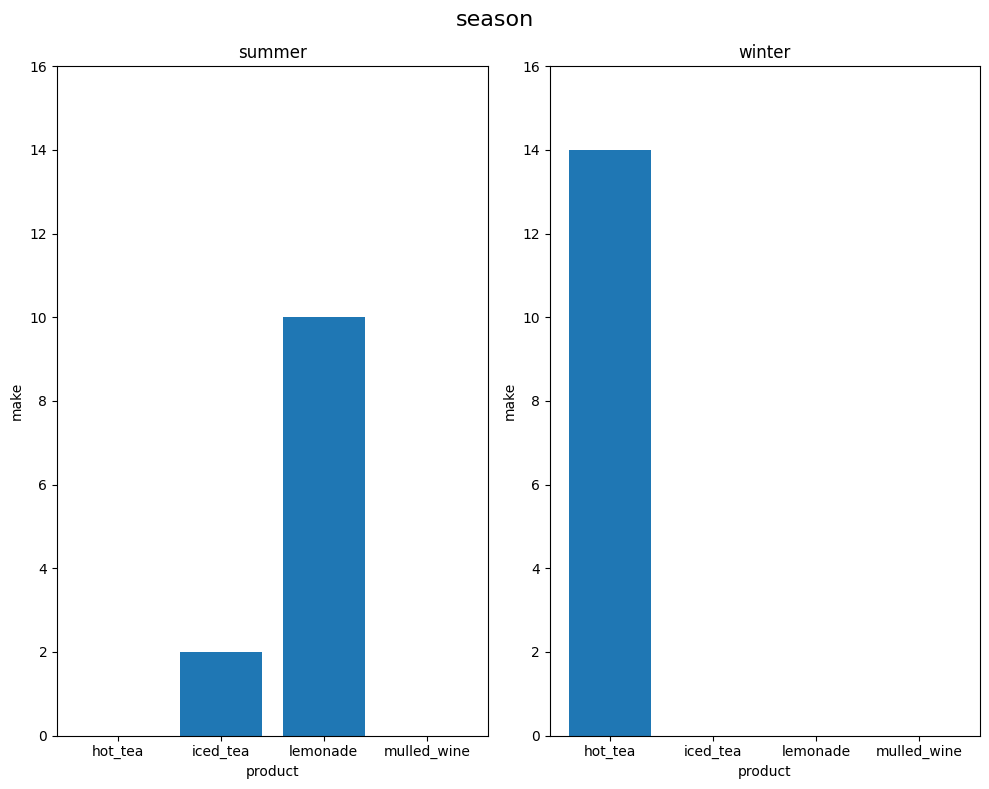

In [24]:
# Create an AMPL object
ampl = AMPL()

# Load the AMPL script that contains the model and data as well as the objective function adjustment
ampl.read("multi_production_adj.run")

# Set solver and solve
ampl.solve(solver="gurobi")
assert ampl.solve_result == "solved"

# Get the 'make' and 'profit_per_product' data from the model,
# convert it to a pandas DataFrame, reset the index, and rename the index columns for better walkability
sol_df = ampl.get_data("make", "profit_per_product").to_pandas().reset_index()
sol_df.rename(columns={"index0": "product", "index1": "season"}, inplace=True)

# Walk the solution data frame
fig, axes = plt.subplots(1, 2, figsize=(10, 8), sharex=True)

y_min = 0
y_max = sol_df["make"].max() + 2

summer_data = sol_df[sol_df["season"] == "summer"]
axes[0].bar(summer_data["product"], summer_data["make"])
axes[0].set_title("summer")
axes[0].set_ylabel("make")
axes[0].set_xlabel("product")
axes[0].set_ylim(y_min, y_max)

winter_data = sol_df[sol_df["season"] == "winter"]
axes[1].bar(winter_data["product"], winter_data["make"])
axes[1].set_title("winter")
axes[1].set_ylabel("make")
axes[1].set_xlabel("product")
axes[1].set_ylim(y_min, y_max)

fig.suptitle("season", fontsize=16)

plt.tight_layout()
plt.show()